# Athabasca Glacier Albedo Analysis

## Introduction and Methodology

This analysis compares MODIS satellite-derived albedo measurements with ground-truth automatic weather station (AWS) observations for glacier surface albedo validation. The study employs multiple MODIS products and temporal aggregation approaches to assess the accuracy and reliability of satellite-based albedo retrievals.

### Study Objectives

1. **Evaluate MODIS albedo products** against high-quality ground measurements
2. **Compare different MODIS methods** (MCD43A3 BRDF, MOD09GA surface reflectance, MOD10A1 snow product)
3. **Assess Terra/Aqua data fusion** effectiveness for improved temporal coverage
4. **Analyze temporal patterns** across multiple timescales (daily, weekly, 16-day, monthly)
5. **Identify optimal approaches** for glacier albedo monitoring

### Data Processing Methodology

- **Terra/Aqua Fusion**: Combined Terra and Aqua observations using mean values when both satellites provide data, or single observations when only one is available
- **Temporal Aggregation**: Analysis at multiple scales from daily observations to monthly composites
- **Quality Control**: Systematic outlier detection and statistical validation
- **Spatial Analysis**: Pixel-level comparisons and geographic context evaluation

The following sections present comprehensive statistical comparisons, temporal pattern analysis, and method performance evaluation across different aggregation periods.

# Core & Spatial Library Imports

#### Import and load libraries

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Optional spatial libraries
try:
    import geopandas as gpd
    import contextily as ctx
    from shapely.geometry import Point
    SPATIAL_LIBS = True
    print("Spatial libraries available")
except ImportError:
    SPATIAL_LIBS = False
    print("Warning: Spatial libraries not available. Install geopandas and contextily for spatial analysis.")

Spatial libraries available



#### Glacier Data Catalog and Loader Functions

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# GLACIER CATALOG & LOADING FUNCTIONS
# ──────────────────────────────────────────────────────────────────────────────
from pathlib import Path

# Glacier data catalog - add new glaciers here
CATALOG = {
    "athabasca": {
        "modis_csv": "data/csv/Athabasca_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv",
        "aws_csv":   "data/csv/iceAWS_Atha_albedo_daily_20152020_filled_clean.csv",
        "mask_shp":  "data/mask/masque_athabasa_zone_ablation.shp",
        "aws_pts":   "data/mask/Point_Custom.shp",
    },
    "haig": {
        "modis_csv": "data/csv/Haig_Terra_Aqua_MultiProduct_2014-01-01_to_2021-01-01.csv",
        "aws_csv":   "data/csv/iceAWS_Haig_albedo_daily_20152020_filled_clean.csv",
        "mask_shp":  "data/mask/haig_mask.shp",
        "aws_pts":   "data/mask/haig_aws.shp",
    },
}

def load_glacier(name="athabasca"):
    """Load all data files for the specified glacier"""
    if name not in CATALOG:
        raise ValueError(f"Unknown glacier: {name}. Options: {list(CATALOG)}")
    
    cfg = CATALOG[name]
    modis_df = pd.read_csv(cfg["modis_csv"])
    aws_df   = pd.read_csv(cfg["aws_csv"])
    
    # Load spatial data if available
    if SPATIAL_LIBS:
        try:
            mask_gdf = gpd.read_file(cfg["mask_shp"]) if Path(cfg["mask_shp"]).exists() else None
            aws_gdf  = gpd.read_file(cfg["aws_pts"]) if Path(cfg["aws_pts"]).exists() else None
        except Exception as e:
            print(f"Warning: Could not load spatial data: {e}")
            mask_gdf, aws_gdf = None, None
    else:
        mask_gdf, aws_gdf = None, None
    
    return modis_df, aws_df, mask_gdf, aws_gdf

# ──────────────────────────────────────────────────────────────────────────────
# EXPORT FOLDER & FILE-NAME HELPER
# ──────────────────────────────────────────────────────────────────────────────

# Create exports directory for organized output
EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

def out(filename: str) -> str:
    """Return a glacier-prefixed path inside exports/ directory"""
    return str(EXPORT_DIR / f"{GLACIER}_{filename}")

print(f"✓ Glacier catalog initialized with {len(CATALOG)} glaciers: {list(CATALOG.keys())}")
print(f"📁 All plots and reports will be saved to: {EXPORT_DIR.resolve()}")

✓ Glacier catalog initialized with 2 glaciers: ['athabasca', 'haig']
📁 All plots and reports will be saved to: D:\Documents\Projects\athabasca_analysis\exports


#### Glacier Selection and Data Loading

In [9]:
# ──────────────────────────────────────────────────────────────────────────────
# GLACIER SELECTION & DATA LOADING
# ──────────────────────────────────────────────────────────────────────────────

# ────────────────────────────────────────────────────────────────────────────
# SELECT GLACIER HERE (change to "haig" when needed)
GLACIER = "athabasca"
# ────────────────────────────────────────────────────────────────────────────

# Optional: Interactive widget selector (uncomment if needed)
# try:
#     import ipywidgets as wd
#     from IPython.display import display
#     sel = wd.Dropdown(options=list(CATALOG), value=GLACIER, description="Glacier:")
#     display(sel)
#     sel.observe(lambda ch: globals().update(GLACIER=ch["new"]), names="value")
# except ImportError:
#     pass

# Load the selected glacier data
print(f"🏔️  Loading data for: {GLACIER.upper()}")
modis, aws, glacier_mask, aws_points = load_glacier(GLACIER)

# Display loading results and data information
print(f"✓ MODIS data: {len(modis)} rows, shape: {modis.shape}")
print(f"✓ AWS data: {len(aws)} rows, shape: {aws.shape}")
if glacier_mask is not None:
    print(f"✓ Glacier mask: {len(glacier_mask)} features")
if aws_points is not None:
    print(f"✓ AWS points: {len(aws_points)} features")

# Display basic info about the loaded datasets
print(f"\n📊 MODIS columns: {list(modis.columns)}")
print(f"📊 AWS columns: {list(aws.columns)}")

print(f"\n📁 All outputs will be saved to: exports/{GLACIER}_*")
print(f"🎯 Ready to analyze {GLACIER.upper()} glacier data!")

🏔️  Loading data for: ATHABASCA
✓ MODIS data: 1430 rows, shape: (1430, 24)
✓ AWS data: 2199 rows, shape: (2199, 2)
✓ Glacier mask: 1 features
✓ AWS points: 1 features

📊 MODIS columns: ['pixel_id', 'date', 'qa_mode', 'method', 'albedo', 'glacier_fraction', 'ndsi', 'solar_zenith', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
📊 AWS columns: ['Time', 'Albedo']

📁 All outputs will be saved to: exports/athabasca_*
🎯 Ready to analyze ATHABASCA glacier data!


## 🛰️ Terra/Aqua Data Fusion



In [10]:
# Terra/Aqua merge function
def merge_terra_aqua(df):
    """
    Merge Terra and Aqua observations by taking the mean when both are available,
    or using the single available observation when only one is present.
    """
    df = df.copy()
    # Standardize method names to uppercase
    df['method'] = df['method'].str.upper()
    
    # Determine the albedo column name
    albedo_col = 'albedo' if 'albedo' in df.columns else 'albedo_value'
    
    # Map Terra/Aqua pairs
    product_pairs = {
        'MOD09GA': 'MYD09GA',
        'MOD10A1': 'MYD10A1'
    }
    combined_rows = []
    
    # For each pair, group by date and pixel_id
    for terra, aqua in product_pairs.items():
        terra_df = df[df['method'] == terra]
        aqua_df = df[df['method'] == aqua]
        
        if len(terra_df) == 0 and len(aqua_df) == 0:
            continue
            
        # Merge on date and pixel_id
        merged = pd.merge(
            terra_df,
            aqua_df,
            on=['date', 'pixel_id'],
            suffixes=('_terra', '_aqua'),
            how='outer'
        )
        
        # Get the albedo column names with suffixes
        terra_albedo = f'{albedo_col}_terra'
        aqua_albedo = f'{albedo_col}_aqua'
        
        # Take mean where both are present, else use available
        merged[albedo_col] = merged[[terra_albedo, aqua_albedo]].mean(axis=1)
        merged['method'] = terra  # Use Terra name for combined
        merged['source'] = np.where(
            merged[terra_albedo].notna() & merged[aqua_albedo].notna(),
            'combined',
            np.where(merged[terra_albedo].notna(), 'terra_only', 'aqua_only')
        )
        
        # Keep spatial info from Terra if available, else Aqua
        merged['latitude'] = merged['latitude_terra'].combine_first(merged['latitude_aqua'])
        merged['longitude'] = merged['longitude_terra'].combine_first(merged['longitude_aqua'])
        
        # Keep only relevant columns
        keep_cols = ['date', 'pixel_id', 'method', albedo_col, 'latitude', 'longitude', 'source']
        combined_rows.append(merged[keep_cols])
    
    # Keep all other methods (e.g., MCD43A3) unchanged
    other_methods = df[~df['method'].isin(list(product_pairs.keys()) + list(product_pairs.values()))]
    
    if combined_rows:
        result = pd.concat(combined_rows + [other_methods], ignore_index=True)
    else:
        result = other_methods
        
    return result

In [11]:
# Apply Terra/Aqua merging and process data
print("Applying Terra/Aqua merge...")
modis = merge_terra_aqua(modis)

print(f"Terra/Aqua merge summary:")
print(f"Final MODIS rows: {len(modis)}")
if 'source' in modis.columns:
    print("Source breakdown:")
    print(modis['source'].value_counts())

# Check if we need to rename albedo column
if 'albedo_value' not in modis.columns and 'albedo' in modis.columns:
    modis = modis.rename(columns={'albedo': 'albedo_value'})

# Standardize and convert dates
modis['method'] = modis['method'].str.upper()
modis['date'] = pd.to_datetime(modis['date'])
aws['date'] = pd.to_datetime(aws['Time'])

Applying Terra/Aqua merge...
Terra/Aqua merge summary:
Final MODIS rows: 1298
Source breakdown:
source
terra_only    459
aqua_only     148
combined      132
Name: count, dtype: int64


In [12]:
# Create pivot table and merge with AWS data
modis_pivot = modis.pivot_table(index='date', columns='method', values='albedo_value', aggfunc='mean')
merged = pd.merge(modis_pivot, aws[['date', 'Albedo']], on='date', how='inner')
merged.rename(columns={'Albedo': 'AWS'}, inplace=True)
merged.set_index('date', inplace=True)

# Display final results
print(f"Final analysis results:")
print(f"MODIS processed: {modis.shape}")
print(f"AWS data: {aws.shape}")
print(f"Merged dataset: {merged.shape}")
print(f"Available methods: {list(modis_pivot.columns)}")
print(f"Date range: {merged.index.min()} to {merged.index.max()}")
print(f"Total overlapping observations: {len(merged)}")

# Show sample of merged data
print(f"\nSample of merged data:")
print(merged.head())

Final analysis results:
MODIS processed: (1298, 25)
AWS data: (2199, 3)
Merged dataset: (515, 4)
Available methods: ['MCD43A3', 'MOD09GA', 'MOD10A1']
Date range: 2014-09-12 00:00:00 to 2020-09-18 00:00:00
Total overlapping observations: 515

Sample of merged data:
            MCD43A3   MOD09GA  MOD10A1       AWS
date                                            
2014-09-12    0.203       NaN      NaN       NaN
2014-09-13    0.204  0.591241     0.46  0.753022
2014-09-14    0.209  0.404449     0.35  0.604580
2014-09-15      NaN  0.246590     0.30  0.477196
2014-09-16      NaN  0.251019      NaN  0.368135


In [13]:
# ==============================================================================
# OVERALL STATISTICS CALCULATION
# ==============================================================================
stats_results = {}
for modis_col in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    mask = merged[[modis_col, 'AWS']].notna().all(axis=1)
    if mask.sum() > 0:
        x = merged.loc[mask, modis_col]
        y = merged.loc[mask, 'AWS']
        
        r, p = stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        stats_results[modis_col] = {
            'n': mask.sum(), 'r': r, 'p': p,
            'rmse': rmse, 'mae': mae, 'bias': bias
        }

# Display statistics table
print("OVERALL STATISTICS")
print("=" * 80)
print(f"{'Method':<10} {'n':<6} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 80)
for method, s in stats_results.items():
    print(f"{method:<10} {s['n']:<6} {s['r']:<6.3f} {s['rmse']:<6.3f} {s['mae']:<6.3f} {s['bias']:<6.3f}")
print("=" * 80)

OVERALL STATISTICS
Method     n      r      RMSE   MAE    Bias  
--------------------------------------------------------------------------------
MCD43A3    332    0.642  0.150  0.090  -0.070
MOD09GA    252    0.508  0.123  0.078  -0.028
MOD10A1    139    0.653  0.144  0.107  -0.062


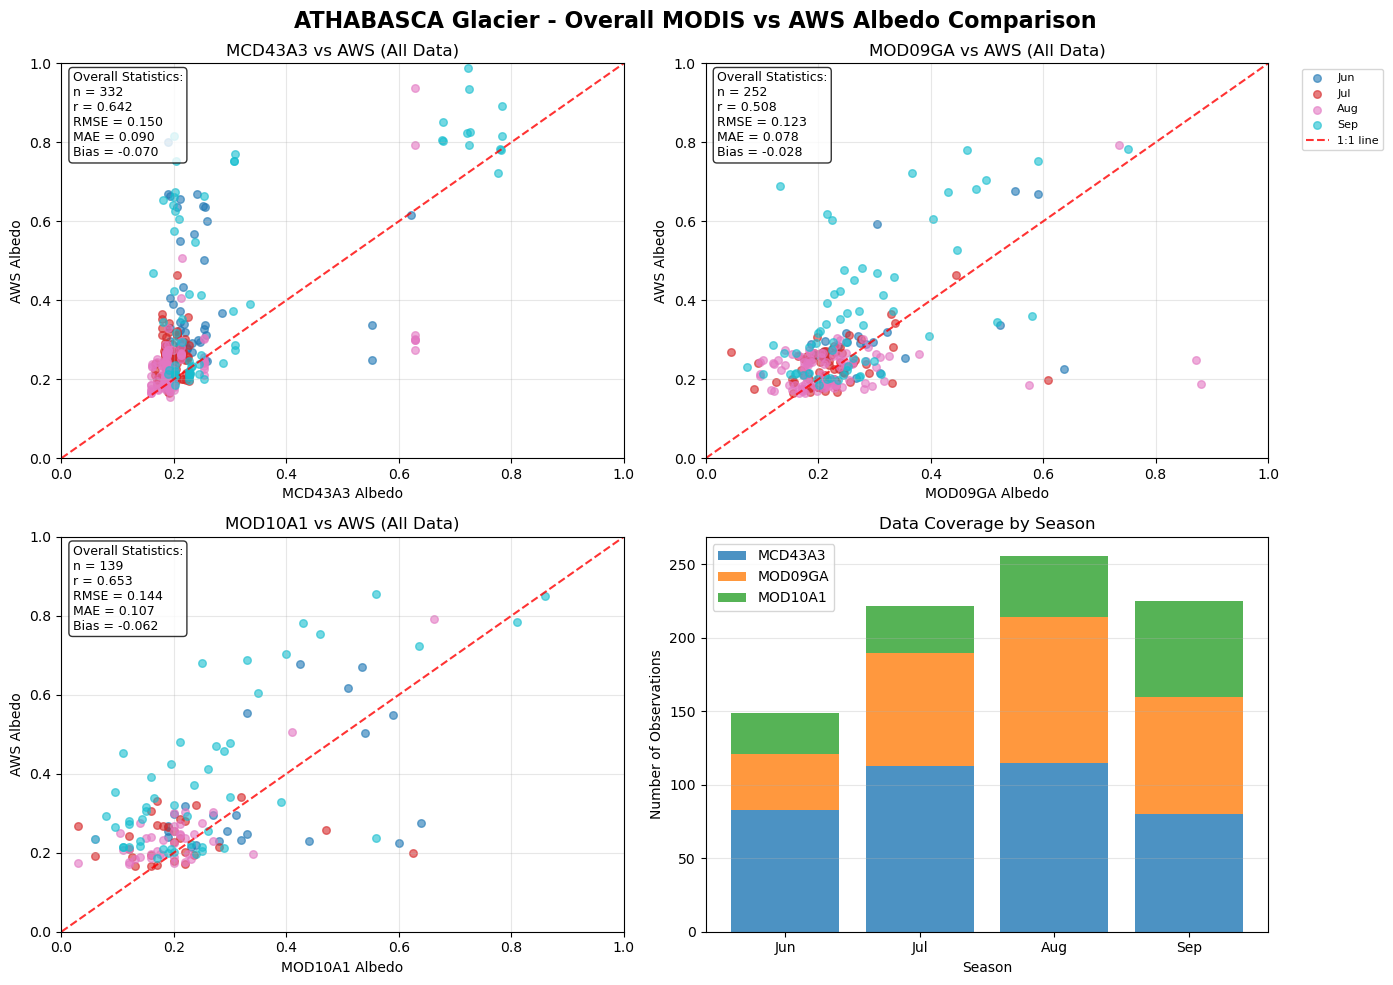


✅ Plot saved to: exports\athabasca_comprehensive_analysis.png

Overall analysis results for ATHABASCA:

MCD43A3:
  Total valid observations: 332
  Correlation: 0.642
  RMSE: 0.150
  MAE: 0.090
  Bias: -0.070

MOD09GA:
  Total valid observations: 252
  Correlation: 0.508
  RMSE: 0.123
  MAE: 0.078
  Bias: -0.028

MOD10A1:
  Total valid observations: 139
  Correlation: 0.653
  RMSE: 0.144
  MAE: 0.107
  Bias: -0.062


In [14]:
# Create comprehensive scatter plots for overall method comparison
from scipy import stats as scipy_stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'{GLACIER.upper()} Glacier - Overall MODIS vs AWS Albedo Comparison', fontsize=16, fontweight='bold')

# Extract month data for seasonal coloring
months = merged.index.month
unique_months = sorted(months.unique())
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'}
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_months)))

for i, method in enumerate(['MCD43A3', 'MOD09GA']):
    if method in merged.columns:
        ax = axes[0, i]
        
        # Calculate overall statistics for this method
        overall_valid = merged[[method, 'AWS']].dropna()
        if len(overall_valid) > 1:
            r, p = scipy_stats.pearsonr(overall_valid[method], overall_valid['AWS'])
            rmse = np.sqrt(np.mean((overall_valid[method] - overall_valid['AWS'])**2))
            mae = np.mean(np.abs(overall_valid[method] - overall_valid['AWS']))
            bias = np.mean(overall_valid[method] - overall_valid['AWS'])
            n_total = len(overall_valid)
        else:
            r, p, rmse, mae, bias, n_total = 0, 1, 0, 0, 0, 0
        
        # Plot all data points colored by season
        for month, color in zip(unique_months, colors):
            month_mask = months == month
            month_data = merged[month_mask]
            
            if len(month_data) > 0:
                valid_data = month_data[[method, 'AWS']].dropna()
                if len(valid_data) > 0:
                    month_label = month_names.get(month, f'Month {month}')
                    ax.scatter(valid_data[method], valid_data['AWS'], 
                             c=[color], alpha=0.6, s=30, 
                             label=month_label)
        
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='1:1 line')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel(f'{method} Albedo')
        ax.set_ylabel('AWS Albedo')
        ax.set_title(f'{method} vs AWS (All Data)')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text box
        stats_text = f'Overall Statistics:\nn = {n_total}\nr = {r:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}\nBias = {bias:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        if i == 1:  # Only show legend on the right plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# MOD10A1 in bottom left
if 'MOD10A1' in merged.columns:
    ax = axes[1, 0]
    
    # Calculate overall statistics for MOD10A1
    overall_valid = merged[['MOD10A1', 'AWS']].dropna()
    if len(overall_valid) > 1:
        r, p = scipy_stats.pearsonr(overall_valid['MOD10A1'], overall_valid['AWS'])
        rmse = np.sqrt(np.mean((overall_valid['MOD10A1'] - overall_valid['AWS'])**2))
        mae = np.mean(np.abs(overall_valid['MOD10A1'] - overall_valid['AWS']))
        bias = np.mean(overall_valid['MOD10A1'] - overall_valid['AWS'])
        n_total = len(overall_valid)
    else:
        r, p, rmse, mae, bias, n_total = 0, 1, 0, 0, 0, 0
    
    # Plot all data points colored by season
    for month, color in zip(unique_months, colors):
        month_mask = months == month
        month_data = merged[month_mask]
        
        if len(month_data) > 0:
            valid_data = month_data[['MOD10A1', 'AWS']].dropna()
            if len(valid_data) > 0:
                month_label = month_names.get(month, f'Month {month}')
                ax.scatter(valid_data['MOD10A1'], valid_data['AWS'], 
                         c=[color], alpha=0.6, s=30, 
                         label=month_label)
    
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.8, label='1:1 line')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('MOD10A1 Albedo')
    ax.set_ylabel('AWS Albedo')
    ax.set_title('MOD10A1 vs AWS (All Data)')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'Overall Statistics:\nn = {n_total}\nr = {r:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}\nBias = {bias:.3f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Data coverage by season in bottom right
ax = axes[1, 1]
if len(unique_months) > 0:
    month_labels = [month_names.get(m, f'M{m}') for m in unique_months]
    
    # Collect data for all methods first
    methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
    data_matrix = []
    
    for method in methods:
        if method in merged.columns:
            counts = []
            for month in unique_months:
                month_mask = months == month
                count = merged[month_mask][method].notna().sum()
                counts.append(count)
            data_matrix.append(counts)
        else:
            data_matrix.append([0] * len(unique_months))
    
    # Create stacked bar chart
    bottom = np.zeros(len(unique_months))
    colors_methods = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    for i, (method, method_counts) in enumerate(zip(methods, data_matrix)):
        if method in merged.columns and any(method_counts):
            ax.bar(month_labels, method_counts, bottom=bottom, 
                  label=method, color=colors_methods[i], alpha=0.8)
            bottom += np.array(method_counts)
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Number of Observations')
    ax.set_title('Data Coverage by Season')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(out('comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Plot saved to: {out('comprehensive_analysis.png')}")

# Print detailed statistics for each method
print(f"\nOverall analysis results for {GLACIER.upper()}:")
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in merged.columns:
        overall_valid = merged[[method, 'AWS']].dropna()
        if len(overall_valid) > 1:
            r, p = scipy_stats.pearsonr(overall_valid[method], overall_valid['AWS'])
            rmse = np.sqrt(np.mean((overall_valid[method] - overall_valid['AWS'])**2))
            mae = np.mean(np.abs(overall_valid[method] - overall_valid['AWS']))
            bias = np.mean(overall_valid[method] - overall_valid['AWS'])
            n_total = len(overall_valid)
            
            print(f"\n{method}:")
            print(f"  Total valid observations: {n_total}")
            print(f"  Correlation: {r:.3f}")
            print(f"  RMSE: {rmse:.3f}")
            print(f"  MAE: {mae:.3f}")
            print(f"  Bias: {bias:.3f}")

# 16-Day Composite Analysis

This section performs a 16-day composite analysis similar to Ren et al. (2023). MODIS data is commonly processed in 16-day composites to reduce cloud contamination and provide more stable albedo estimates. This analysis:

- Groups data into 16-day periods starting from day 1 of each year
- Calculates mean albedo values for each 16-day period
- Compares temporal patterns between MODIS methods and AWS
- Analyzes seasonal dynamics at the 16-day scale

In [15]:
# ==============================================================================
# 16-DAY COMPOSITE ANALYSIS (following Ren et al. 2023 approach)
# ==============================================================================

# Function to calculate 16-day period number
def get_16day_period(date):
    """Calculate 16-day period number (1-23) for a given date"""
    day_of_year = date.timetuple().tm_yday
    period = ((day_of_year - 1) // 16) + 1
    return min(period, 23)  # Cap at 23 periods per year

# Add 16-day period information to merged data
merged_16day = merged.copy()
merged_16day['year'] = merged_16day.index.year
merged_16day['day_of_year'] = merged_16day.index.dayofyear
merged_16day['period_16day'] = merged_16day.index.map(get_16day_period)
merged_16day['year_period'] = merged_16day['year'].astype(str) + '_P' + merged_16day['period_16day'].astype(str).str.zfill(2)

# Calculate 16-day composites (mean values)
composite_16day = merged_16day.groupby(['year', 'period_16day']).agg({
    'MCD43A3': ['mean', 'std', 'count'],
    'MOD09GA': ['mean', 'std', 'count'],
    'MOD10A1': ['mean', 'std', 'count'],
    'AWS': ['mean', 'std', 'count']
}).round(4)

# Flatten column names
composite_16day.columns = ['_'.join(col).strip() for col in composite_16day.columns]
composite_16day = composite_16day.reset_index()

# Create period start dates for plotting
composite_16day['period_start'] = pd.to_datetime(
    composite_16day['year'].astype(str) + '-01-01'
) + pd.to_timedelta((composite_16day['period_16day'] - 1) * 16, unit='days')

print("16-DAY COMPOSITE ANALYSIS")
print("=" * 50)
print(f"Total 16-day periods analyzed: {len(composite_16day)}")
print(f"Year range: {composite_16day['year'].min()} - {composite_16day['year'].max()}")
print(f"Period range: {composite_16day['period_16day'].min()} - {composite_16day['period_16day'].max()}")
print(f"Date range: {composite_16day['period_start'].min().strftime('%Y-%m-%d')} to {composite_16day['period_start'].max().strftime('%Y-%m-%d')}")
print("=" * 50)

# Display sample of 16-day composites
print("\nSample 16-day composites:")
print(composite_16day[['year', 'period_16day', 'MCD43A3_mean', 'MOD09GA_mean', 'MOD10A1_mean', 'AWS_mean']].head(10).round(3))

16-DAY COMPOSITE ANALYSIS
Total 16-day periods analyzed: 53
Year range: 2014 - 2020
Period range: 10 - 18
Date range: 2014-08-29 to 2020-09-13

Sample 16-day composites:
   year  period_16day  MCD43A3_mean  MOD09GA_mean  MOD10A1_mean  AWS_mean
0  2014            16         0.204         0.591         0.460     0.753
1  2014            17         0.236         0.289         0.254     0.405
2  2015            10         0.291         0.232         0.312       NaN
3  2015            11         0.248         0.288         0.317       NaN
4  2015            12         0.205         0.211         0.151       NaN
5  2015            13         0.198         0.269         0.147     0.326
6  2015            14         0.188         0.225         0.227     0.281
7  2015            15         0.436         0.285         0.353     0.378
8  2015            16         0.251         0.215         0.254     0.378
9  2015            17         0.323         0.493         0.504     0.758


In [16]:
# Create 16-day composite statistics
from scipy import stats as scipy_stats  # Rename to avoid conflict

print("\n16-DAY COMPOSITE STATISTICS")
print("="*50)

composite_stats = {}
for modis_col in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    modis_mean = f'{modis_col}_mean'
    aws_mean = 'AWS_mean'
    
    # Get valid observations
    valid_data = composite_16day[[modis_mean, aws_mean]].dropna()
    
    if len(valid_data) >= 3:  # Need at least 3 points for meaningful statistics
        x = valid_data[modis_mean]
        y = valid_data[aws_mean]
        
        # Calculate correlation and statistics
        r, p = scipy_stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        composite_stats[modis_col] = {
            'n_periods': len(valid_data),
            'r': r,
            'p': p,
            'rmse': rmse,
            'mae': mae,
            'bias': bias,
            'data': valid_data  # Add the data for plotting
        }
        
        print(f"\n{modis_col} vs AWS (16-day composites):")
        print(f"  N periods: {len(valid_data)}")
        print(f"  Correlation: {r:.3f} (p={p:.3f})")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  Bias: {bias:.3f}")
    else:
        print(f"\n{modis_col}: Insufficient data for 16-day composite analysis")

# Store in the comprehensive stats
for method, stat_dict in composite_stats.items():
    s[f'{method}_16day_composite'] = stat_dict


16-DAY COMPOSITE STATISTICS

MCD43A3 vs AWS (16-day composites):
  N periods: 37
  Correlation: 0.613 (p=0.000)
  RMSE: 0.157
  MAE: 0.103
  Bias: -0.092

MOD09GA vs AWS (16-day composites):
  N periods: 45
  Correlation: 0.842 (p=0.000)
  RMSE: 0.111
  MAE: 0.082
  Bias: -0.062

MOD10A1 vs AWS (16-day composites):
  N periods: 43
  Correlation: 0.641 (p=0.000)
  RMSE: 0.142
  MAE: 0.107
  Bias: -0.058


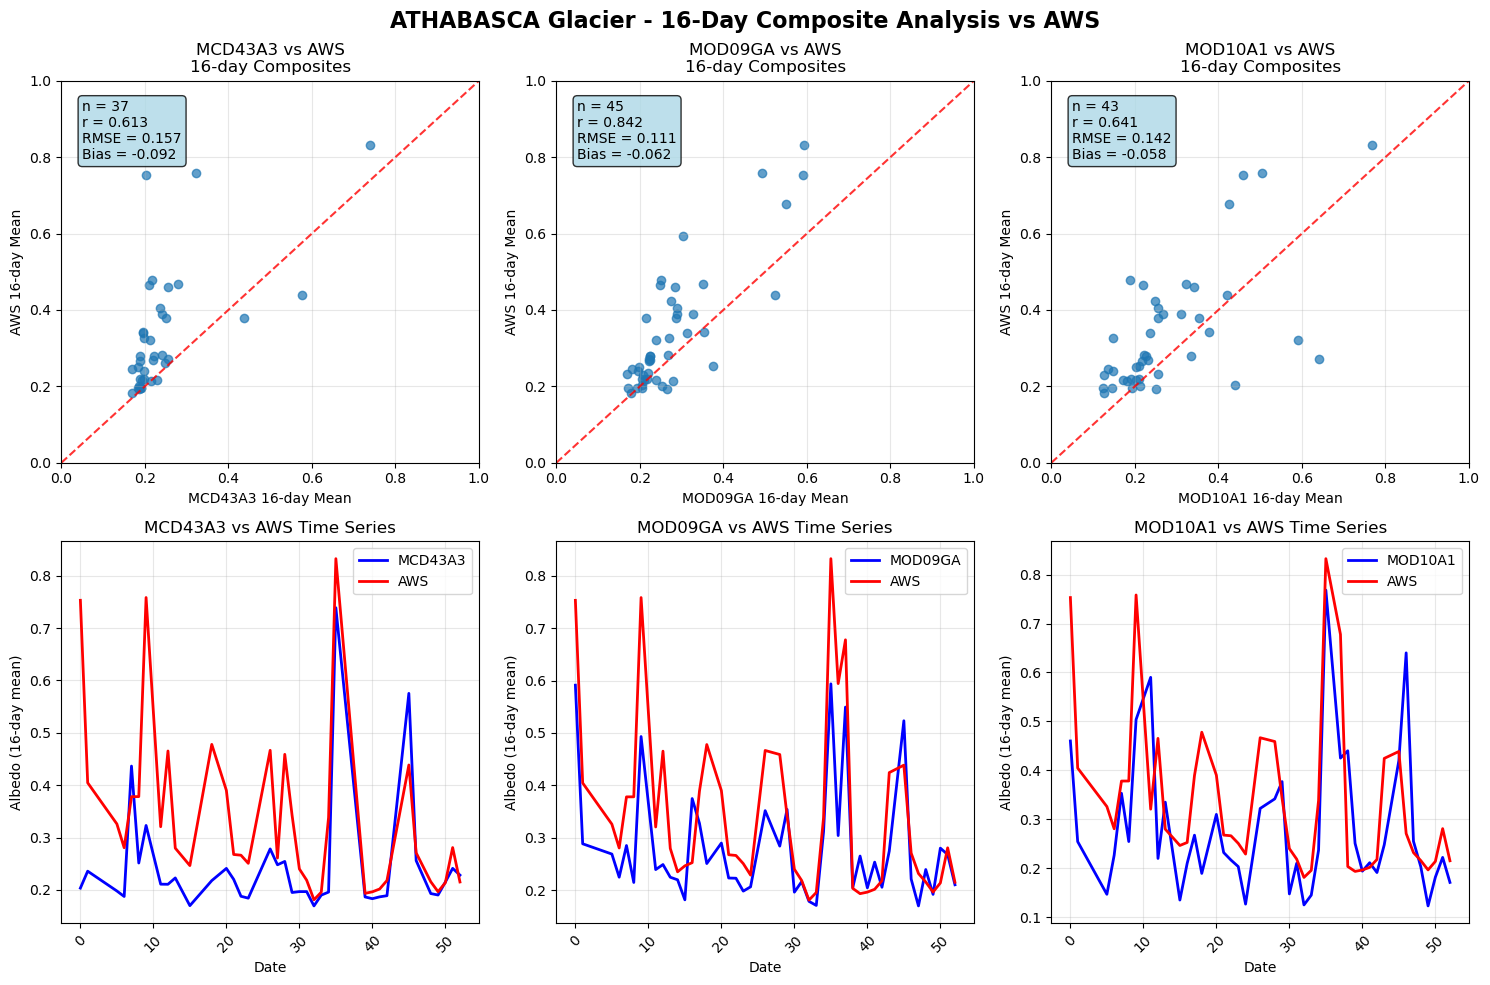


16-day composite analysis results for ATHABASCA:

MCD43A3:
  Valid 16-day periods: 37
  Correlation: 0.613
  RMSE: 0.157
  MAE: 0.103
  Bias: -0.092

MOD09GA:
  Valid 16-day periods: 45
  Correlation: 0.842
  RMSE: 0.111
  MAE: 0.082
  Bias: -0.062

MOD10A1:
  Valid 16-day periods: 43
  Correlation: 0.641
  RMSE: 0.142
  MAE: 0.107
  Bias: -0.058


In [17]:
# Create comprehensive 16-day analysis visualization
fig, axes = plt.subplots(2, len(composite_stats), figsize=(5*len(composite_stats), 10))
if len(composite_stats) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle(f'{GLACIER.upper()} Glacier - 16-Day Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(composite_stats.items()):
    if stats_dict['n_periods'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[0, i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} 16-day Mean')
        ax1.set_ylabel('AWS 16-day Mean')
        ax1.set_title(f'{method} vs AWS\n16-day Composites')
        ax1.grid(True, alpha=0.3)
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        # Time series
        ax2 = axes[1, i]
        ax2.plot(data.index, data[method_col], 'b-', label=f'{method}', linewidth=2)
        ax2.plot(data.index, data[aws_col], 'r-', label='AWS', linewidth=2)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Albedo (16-day mean)')
        ax2.set_title(f'{method} vs AWS Time Series')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        axes[0, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.savefig(out('16day_composite_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n16-day composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in composite_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid 16-day periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for 16-day composite analysis")

# Weekly Composite Analysis

This section performs a weekly (7-day) composite analysis to compare with the 16-day approach.


In [18]:
# ==============================================================================
# WEEKLY COMPOSITE ANALYSIS
# ==============================================================================

# Create weekly composites for comparison with 16-day analysis
def get_week_of_year(date):
    """Get week of year (1-53) for a given date"""
    return date.isocalendar()[1]

# Prepare data for weekly compositing
merged_weekly = merged.copy()
merged_weekly['year'] = merged_weekly.index.year
merged_weekly['week'] = merged_weekly.index.map(get_week_of_year)
merged_weekly['year_week'] = merged_weekly['year'].astype(str) + '_W' + merged_weekly['week'].astype(str).str.zfill(2)

# Calculate weekly composites (mean values)
composite_weekly = merged_weekly.groupby(['year', 'week']).agg({
    'MCD43A3': ['mean', 'std', 'count'],
    'MOD09GA': ['mean', 'std', 'count'],
    'MOD10A1': ['mean', 'std', 'count'],
    'AWS': ['mean', 'std', 'count']
}).round(4)

# Flatten column names
composite_weekly.columns = ['_'.join(col).strip() for col in composite_weekly.columns]
composite_weekly = composite_weekly.reset_index()

# Create week start dates for plotting
composite_weekly['week_start'] = pd.to_datetime(
    composite_weekly['year'].astype(str) + '-01-01'
) + pd.to_timedelta((composite_weekly['week'] - 1) * 7, unit='days')

# Add month information
composite_weekly['month'] = composite_weekly['week_start'].dt.month

# Filter for only months with data for all 3 methods (June, July, August, September)
target_months = [6, 7, 8, 9]  # June, July, August, September
composite_weekly = composite_weekly[composite_weekly['month'].isin(target_months)]

print("WEEKLY COMPOSITE ANALYSIS")
print("=" * 50)
print(f"Total weekly periods analyzed: {len(composite_weekly)}")
print(f"Year range: {composite_weekly['year'].min()} - {composite_weekly['year'].max()}")
print(f"Week range: {composite_weekly['week'].min()} - {composite_weekly['week'].max()}")
print(f"Date range: {composite_weekly['week_start'].min().strftime('%Y-%m-%d')} to {composite_weekly['week_start'].max().strftime('%Y-%m-%d')}")
print(f"Months included: {sorted(composite_weekly['month'].unique())} (June-September only)")
print("=" * 50)

# Display sample of weekly composites
print("\nSample weekly composites:")
print(composite_weekly[['year', 'week', 'MCD43A3_mean', 'MOD09GA_mean', 'MOD10A1_mean', 'AWS_mean']].head(10).round(3))

WEEKLY COMPOSITE ANALYSIS
Total weekly periods analyzed: 101
Year range: 2014 - 2020
Week range: 23 - 39
Date range: 2014-09-10 to 2020-09-16
Months included: [np.int32(6), np.int32(7), np.int32(8), np.int32(9)] (June-September only)

Sample weekly composites:
    year  week  MCD43A3_mean  MOD09GA_mean  MOD10A1_mean  AWS_mean
0   2014    37         0.205         0.498         0.405     0.679
1   2014    38         0.260         0.252         0.255     0.380
2   2014    39         0.214         0.285         0.222     0.393
4   2015    23         0.296           NaN         0.370       NaN
5   2015    24         0.274         0.238         0.262       NaN
6   2015    25         0.244         0.329         0.340       NaN
7   2015    26         0.221         0.234           NaN       NaN
8   2015    27         0.200         0.229         0.182       NaN
9   2015    28         0.204         0.192         0.060       NaN
10  2015    29         0.206         0.344           NaN     0.333


In [19]:
# Calculate statistics for weekly composites
from scipy import stats as scipy_stats  # Rename to avoid conflict

weekly_stats = {}
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    method_mean = f'{method}_mean'
    aws_mean = 'AWS_mean'
    
    # Filter periods with valid data for both MODIS and AWS
    valid_mask = composite_weekly[[method_mean, aws_mean]].notna().all(axis=1)
    valid_data = composite_weekly[valid_mask]
    
    if len(valid_data) > 0:
        x = valid_data[method_mean]
        y = valid_data[aws_mean]
        
        # Calculate correlation and statistics
        r, p = scipy_stats.pearsonr(x, y)
        rmse = np.sqrt(np.mean((x - y)**2))
        mae = np.mean(np.abs(x - y))
        bias = np.mean(x - y)
        
        weekly_stats[method] = {
            'n_periods': len(valid_data),
            'r': r,
            'p': p,
            'rmse': rmse,
            'mae': mae,
            'bias': bias,
            'data': valid_data  # Add data for plotting
        }

# Display weekly composite statistics
print("\nWEEKLY COMPOSITE STATISTICS (Period Averages)")
print("=" * 60)
print(f"{'Method':<10} {'Periods':<8} {'r':<6} {'p-value':<8} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 60)
for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in weekly_stats:
        stats_dict = weekly_stats[method]
        print(f"{method:<10} {stats_dict['n_periods']:<8} {stats_dict['r']:<6.3f} {stats_dict['p']:<8.6f} {stats_dict['rmse']:<6.3f} {stats_dict['mae']:<6.3f} {stats_dict['bias']:<6.3f}")

# Monthly breakdown of weekly composite periods (filtered for target months)
print(f"\nMonthly breakdown of weekly composite periods:")
monthly_counts = composite_weekly['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num, count in monthly_counts.items():
    month_name = month_names[month_num - 1]
    print(f"  {month_name}: {count} periods")
print(f"Total: {monthly_counts.sum()} periods (June-September only)")

# Compare 16-day vs Weekly statistics
print("\n" + "="*80)
print("COMPARISON: 16-DAY vs WEEKLY COMPOSITE STATISTICS (Target Months Only)")
print("="*80)
print(f"{'Method':<10} {'Period':<8} {'n':<6} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-"*80)

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    # 16-day stats
    if method in composite_stats:
        stats_16d = composite_stats[method]
        print(f"{method:<10} {'16-day':<8} {stats_16d['n_periods']:<6} {stats_16d['r']:<6.3f} {stats_16d['rmse']:<6.3f} {stats_16d['mae']:<6.3f} {stats_16d['bias']:<6.3f}")
    
    # Weekly stats
    if method in weekly_stats:
        stats_week = weekly_stats[method]
        print(f"{method:<10} {'Weekly':<8} {stats_week['n_periods']:<6} {stats_week['r']:<6.3f} {stats_week['rmse']:<6.3f} {stats_week['mae']:<6.3f} {stats_week['bias']:<6.3f}")
        
        # Calculate improvement percentages
        if method in composite_stats:
            r_change = ((stats_week['r'] - stats_16d['r']) / abs(stats_16d['r'])) * 100 if stats_16d['r'] != 0 else 0
            rmse_change = ((stats_16d['rmse'] - stats_week['rmse']) / stats_16d['rmse']) * 100 if stats_16d['rmse'] != 0 else 0
            n_change = stats_week['n_periods'] - stats_16d['n_periods']
            print(f"{method:<10} {'Change':<8} {n_change:<6} {r_change:<6.1f}% {rmse_change:<6.1f}% {'':<6} {'':<6}")
    print()

print("Notes:")
print("- Change: Weekly vs 16-day (positive r% = better correlation, positive RMSE% = lower error)")
print("- n: Number of valid periods with both MODIS and AWS data")


WEEKLY COMPOSITE STATISTICS (Period Averages)
Method     Periods  r      p-value  RMSE   MAE    Bias  
------------------------------------------------------------
MCD43A3    67       0.579  0.000000 0.159  0.106  -0.085
MOD09GA    83       0.623  0.000000 0.127  0.088  -0.047
MOD10A1    69       0.742  0.000000 0.132  0.101  -0.064

Monthly breakdown of weekly composite periods:
  Jun: 23 periods
  Jul: 28 periods
  Aug: 24 periods
  Sep: 26 periods
Total: 101 periods (June-September only)

COMPARISON: 16-DAY vs WEEKLY COMPOSITE STATISTICS (Target Months Only)
Method     Period   n      r      RMSE   MAE    Bias  
--------------------------------------------------------------------------------
MCD43A3    16-day   37     0.613  0.157  0.103  -0.092
MCD43A3    Weekly   67     0.579  0.159  0.106  -0.085
MCD43A3    Change   30     -5.4  % -1.4  %              

MOD09GA    16-day   45     0.842  0.111  0.082  -0.062
MOD09GA    Weekly   83     0.623  0.127  0.088  -0.047
MOD09GA    Change

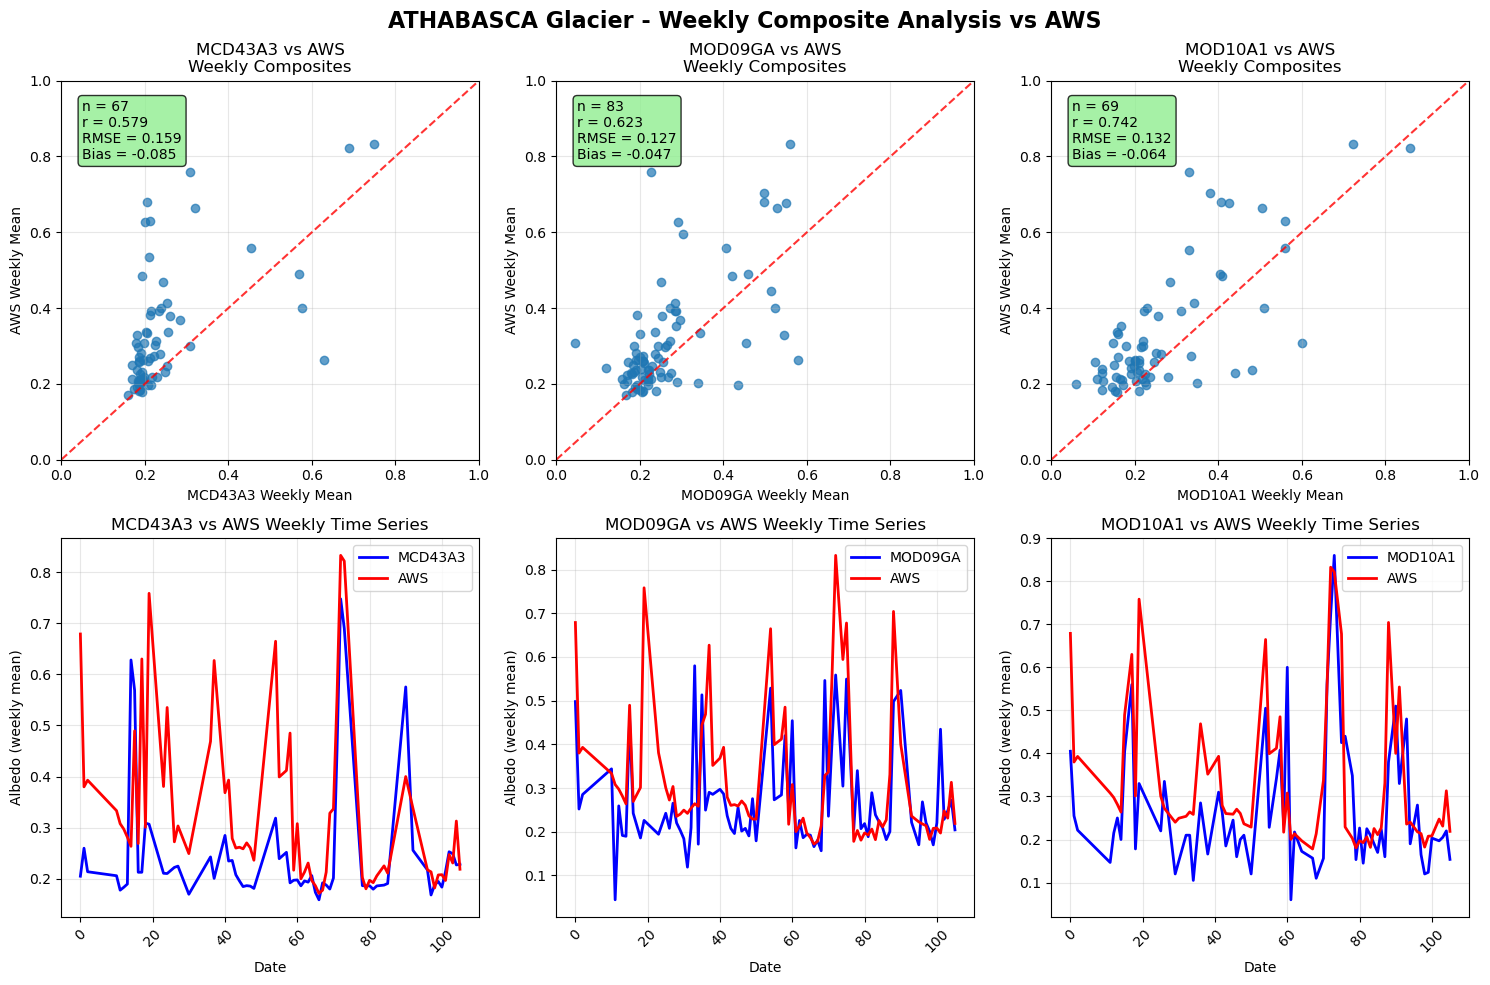


Weekly composite analysis results for ATHABASCA:

MCD43A3:
  Valid weekly periods: 67
  Correlation: 0.579
  RMSE: 0.159
  MAE: 0.106
  Bias: -0.085

MOD09GA:
  Valid weekly periods: 83
  Correlation: 0.623
  RMSE: 0.127
  MAE: 0.088
  Bias: -0.047

MOD10A1:
  Valid weekly periods: 69
  Correlation: 0.742
  RMSE: 0.132
  MAE: 0.101
  Bias: -0.064


In [20]:
# Create comprehensive weekly analysis visualization
fig, axes = plt.subplots(2, len(weekly_stats), figsize=(5*len(weekly_stats), 10))
if len(weekly_stats) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle(f'{GLACIER.upper()} Glacier - Weekly Composite Analysis vs AWS', fontsize=16, fontweight='bold')

for i, (method, stats_dict) in enumerate(weekly_stats.items()):
    if stats_dict['n_periods'] > 0:
        data = stats_dict['data']
        method_col = f'{method}_mean'
        aws_col = 'AWS_mean'
        
        # Scatter plot
        ax1 = axes[0, i]
        ax1.scatter(data[method_col], data[aws_col], alpha=0.7)
        ax1.plot([0, 1], [0, 1], 'r--', alpha=0.8)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(f'{method} Weekly Mean')
        ax1.set_ylabel('AWS Weekly Mean')
        ax1.set_title(f'{method} vs AWS\nWeekly Composites')
        ax1.grid(True, alpha=0.3)
        
        # Statistics text
        stats_text = (f"n = {stats_dict['n_periods']}\n"
                     f"r = {stats_dict['r']:.3f}\n"
                     f"RMSE = {stats_dict['rmse']:.3f}\n"
                     f"Bias = {stats_dict['bias']:.3f}")
        ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
        
        # Time series
        ax2 = axes[1, i]
        ax2.plot(data.index, data[method_col], 'b-', label=f'{method}', linewidth=2)
        ax2.plot(data.index, data[aws_col], 'r-', label='AWS', linewidth=2)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Albedo (weekly mean)')
        ax2.set_title(f'{method} vs AWS Weekly Time Series')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        axes[0, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[0, i].transAxes)
        axes[1, i].text(0.5, 0.5, f'No valid data\nfor {method}', 
                       ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.savefig(out('weekly_composite_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nWeekly composite analysis results for {GLACIER.upper()}:")
for method, stats_dict in weekly_stats.items():
    if stats_dict['n_periods'] > 0:
        print(f"\n{method}:")
        print(f"  Valid weekly periods: {stats_dict['n_periods']}")
        print(f"  Correlation: {stats_dict['r']:.3f}")
        print(f"  RMSE: {stats_dict['rmse']:.3f}")
        print(f"  MAE: {stats_dict['mae']:.3f}")
        print(f"  Bias: {stats_dict['bias']:.3f}")
    else:
        print(f"\n{method}: No valid data for weekly composite analysis")

# Monthly Analysis by Method

This section analyzes albedo patterns by month to understand seasonal variations and how different MODIS methods perform across different times of the year. 

In [21]:
# ==============================================================================
# MONTHLY STATISTICS BY METHOD
# ==============================================================================

from scipy import stats as scipy_stats  # Rename to avoid conflict

# Extract month from index
merged['month'] = merged.index.month
target_months = [6, 7, 8, 9]  # June, July, August, September
months = merged['month']

print("MONTHLY STATISTICS BY METHOD")
print("="*40)
print(f"{'Month':<6} {'Method':<10} {'n':<5} {'r':<6} {'RMSE':<6}")
print("-"*40)

monthly_stats = {}
for month in target_months:
    month_mask = months == month
    month_data = merged[month_mask]
    
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            
            if len(valid_data) >= 5:  # Minimum 5 observations
                x = valid_data[method]
                y = valid_data['AWS']
                
                r, p = scipy_stats.pearsonr(x, y)
                rmse = np.sqrt(np.mean((x - y)**2))
                
                monthly_stats[f"{month}_{method}"] = {
                    'month': month,
                    'method': method,
                    'n': len(valid_data),
                    'r': r,
                    'p': p,
                    'rmse': rmse
                }
                
                month_name = ['Jun', 'Jul', 'Aug', 'Sep'][month - 6]
                print(f"{month_name:<6} {method:<10} {len(valid_data):<5} {r:<6.3f} {rmse:<6.3f}")

# Store outlier detection results
outlier_counts_by_month = {}
outlier_data_by_month = {}

print("\nOUTLIER DETECTION BY MONTH")
print("="*40)

for month in target_months:
    month_mask = months == month
    month_data = merged[month_mask]
    
    outlier_counts_by_month[month] = {}
    outlier_data_by_month[month] = {}
    
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = month_data[[method, 'AWS']].dropna()
            
            if len(valid_data) >= 5:
                # Calculate residuals
                residuals = valid_data[method] - valid_data['AWS']
                
                # Define outliers as |residual| > 2*std
                threshold = 2 * np.std(residuals)
                outliers = np.abs(residuals) > threshold
                
                outlier_counts_by_month[month][method] = np.sum(outliers)
                outlier_data_by_month[month][method] = valid_data[outliers]
                
                month_name = ['Jun', 'Jul', 'Aug', 'Sep'][month - 6]
                print(f"{month_name} {method}: {np.sum(outliers)} outliers ({np.sum(outliers)/len(valid_data)*100:.1f}%)")

print(f"\nAnalyzed months: June-September")
print(f"Total observations across all methods and months: {len(merged[merged['month'].isin(target_months)])}")
print(f"Outlier threshold: ±2 standard deviations from residuals")

MONTHLY STATISTICS BY METHOD
Month  Method     n     r      RMSE  
----------------------------------------
Jun    MCD43A3    54    0.089  0.217 
Jun    MOD09GA    27    0.552  0.119 
Jun    MOD10A1    22    0.494  0.153 
Jul    MCD43A3    100   0.151  0.070 
Jul    MOD09GA    69    0.363  0.075 
Jul    MOD10A1    28    0.074  0.124 
Aug    MCD43A3    115   0.596  0.095 
Aug    MOD09GA    95    0.363  0.121 
Aug    MOD10A1    39    0.829  0.076 
Sep    MCD43A3    63    0.704  0.233 
Sep    MOD09GA    61    0.632  0.166 
Sep    MOD10A1    50    0.731  0.186 

OUTLIER DETECTION BY MONTH
Jun MCD43A3: 8 outliers (14.8%)
Jun MOD09GA: 2 outliers (7.4%)
Jun MOD10A1: 2 outliers (9.1%)
Jul MCD43A3: 13 outliers (13.0%)
Jul MOD09GA: 2 outliers (2.9%)
Jul MOD10A1: 1 outliers (3.6%)
Aug MCD43A3: 8 outliers (7.0%)
Aug MOD09GA: 3 outliers (3.2%)
Aug MOD10A1: 6 outliers (15.4%)
Sep MCD43A3: 13 outliers (20.6%)
Sep MOD09GA: 5 outliers (8.2%)
Sep MOD10A1: 8 outliers (16.0%)

Analyzed months: June-Septem

# Spatial Analysis: Pixel-Level Comparisons and Geographic Context



## Part 1: Multi-Method Pixel Matching

This analysis identifies pixels where multiple MODIS methods (MCD43A3, MOD09GA, MOD10A1) have simultaneous observations, enabling direct method-to-method comparisons at identical spatial and temporal coordinates.

In [22]:
# ===============================================================================
# PIXEL-LEVEL COMPARISON (MOD09GA vs MOD10A1 vs MCD43A3)
# ===============================================================================

# Filter for MOD09GA, MOD10A1, and MCD43A3 only
mod_data = modis[modis['method'].isin(['MOD09GA', 'MOD10A1', 'MCD43A3'])].copy()

# Find matching observations (same date and pixel_id)
mod09_data = mod_data[mod_data['method'] == 'MOD09GA'][['date', 'pixel_id', 'albedo_value']]
mod10_data = mod_data[mod_data['method'] == 'MOD10A1'][['date', 'pixel_id', 'albedo_value']]
mcd43a3_data = mod_data[mod_data['method'] == 'MCD43A3'][['date', 'pixel_id', 'albedo_value']]

# Merge MOD09GA and MOD10A1 on exact date and pixel_id matches
pixel_matched_09_10 = pd.merge(mod09_data, mod10_data, on=['date', 'pixel_id'], suffixes=('_MOD09GA', '_MOD10A1'))

# Merge all three (inner join: only dates/pixels present in all three)
pixel_matched_all = pd.merge(pixel_matched_09_10, mcd43a3_data, on=['date', 'pixel_id'])
pixel_matched_all = pixel_matched_all.rename(columns={'albedo_value': 'albedo_value_MCD43A3'})

print(f"Found {len(pixel_matched_09_10)} matching observations between MOD09GA and MOD10A1")
if len(pixel_matched_09_10) > 0:
    print(f"Date range: {pixel_matched_09_10['date'].min()} to {pixel_matched_09_10['date'].max()}")
    print(f"Unique pixels: {pixel_matched_09_10['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched_09_10['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id (MOD09GA vs MOD10A1)")

print(f"\nFound {len(pixel_matched_all)} matching observations between MOD09GA, MOD10A1, and MCD43A3")
if len(pixel_matched_all) > 0:
    print(f"Date range: {pixel_matched_all['date'].min()} to {pixel_matched_all['date'].max()}")
    print(f"Unique pixels: {pixel_matched_all['pixel_id'].nunique()}")
    print(f"Pixel IDs: {sorted(pixel_matched_all['pixel_id'].unique())}")
else:
    print("No matching observations found for same date and pixel_id (all three products)")

Found 160 matching observations between MOD09GA and MOD10A1
Date range: 2014-06-01 00:00:00 to 2020-09-30 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]

Found 64 matching observations between MOD09GA, MOD10A1, and MCD43A3
Date range: 2014-06-01 00:00:00 to 2020-09-27 00:00:00
Unique pixels: 2
Pixel IDs: [np.int64(9073025950), np.int64(9075025945)]


## Part 2: AWS Station Integration

This section processes the AWS (Automatic Weather Station) ground truth data, extracts station coordinates, and attempts to link AWS measurements with MODIS satellite observations at the same geographic location.

In [23]:
# Process pixel AWS data to match the MODIS data structure
from scipy import stats as scipy_stats  # Rename to avoid conflict

# Get AWS coordinates from the spatial points (from shapefile)
if len(aws_points) > 0:
    aws_lat = aws_points.iloc[0]['latitude']
    aws_lon = aws_points.iloc[0]['longitude']
    
    # Create AWS pixel data structure
    pixel_aws = pd.DataFrame({
        'lat': [aws_lat],
        'lon': [aws_lon],
        'AWS': [aws['Albedo'].mean()]  # Use mean albedo as representative value
    })
    
    print(f"AWS station coordinates: lat={aws_lat:.6f}, lon={aws_lon:.6f}")
    print(f"AWS mean albedo: {aws['Albedo'].mean():.3f}")

    # If pixel_id for AWS is known, compare all three products at that pixel
    if 'pixel_id' in aws and 'date' in aws:
        # Find all MODIS products at AWS pixel and dates
        aws_pixel_id = aws['pixel_id'].iloc[0] if 'pixel_id' in aws.columns else None
        if aws_pixel_id is not None:
            aws_dates = aws['date'].unique() if 'date' in aws.columns else []
            for date in aws_dates:
                row = {'date': date}
                for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
                    val = modis[(modis['pixel_id'] == aws_pixel_id) & (modis['date'] == date) & (modis['method'] == method)]['albedo_value']
                    row[method] = val.iloc[0] if not val.empty else None
                row['AWS'] = aws[aws['date'] == date]['Albedo'].iloc[0] if not aws[aws['date'] == date].empty else None
                print(row)
else:
    print("No AWS points found.")

AWS station coordinates: lat=52.191833, lon=-117.251639
AWS mean albedo: 0.610


In [31]:
# ===============================================================================
# COMPREHENSIVE SPATIAL MAPPING: PIXELS BY METHOD WITH GLACIER MASK & AWS
# ===============================================================================

print("Creating comprehensive spatial maps for each MODIS method...")

# Process MODIS data to get pixel locations and method availability
modis_spatial = modis.copy()

# Check column names and rename if needed
if 'albedo' in modis_spatial.columns and 'albedo_value' not in modis_spatial.columns:
    modis_spatial = modis_spatial.rename(columns={'albedo': 'albedo_value'})

print(f"Available columns: {list(modis_spatial.columns)}")
print(f"Albedo column: {'albedo_value' if 'albedo_value' in modis_spatial.columns else 'albedo'}")

# Extract unique pixel locations with coordinates
albedo_col = 'albedo_value' if 'albedo_value' in modis_spatial.columns else 'albedo'

pixel_locations = modis_spatial.groupby('pixel_id').agg({
    'latitude': 'first',
    'longitude': 'first',
    'method': lambda x: list(x.unique()),  # List of methods available at each pixel
    albedo_col: 'count'  # Count of observations
}).reset_index()

# Count methods per pixel
pixel_locations['n_methods'] = pixel_locations['method'].apply(len)
pixel_locations['methods_available'] = pixel_locations['method'].apply(lambda x: ', '.join(sorted(x)))

# Create individual method pixel datasets
methods = ['MOD09GA', 'MOD10A1', 'MCD43A3']
method_pixels = {}

for method in methods:
    method_data = modis_spatial[modis_spatial['method'] == method]
    if len(method_data) > 0:
        method_pixels[method] = method_data.groupby('pixel_id').agg({
            'latitude': 'first',
            'longitude': 'first',
            albedo_col: ['count', 'mean', 'std']
        }).reset_index()
        
        # Flatten column names
        method_pixels[method].columns = ['pixel_id', 'latitude', 'longitude', 'n_obs', 'mean_albedo', 'std_albedo']
        method_pixels[method]['method'] = method
        
        print(f"✓ {method}: {len(method_pixels[method])} pixels, {method_data.shape[0]} total observations")
    else:
        method_pixels[method] = pd.DataFrame()
        print(f"✗ {method}: No data available")

# Get AWS coordinates
if aws_points is not None and len(aws_points) > 0:
    aws_lat = aws_points.iloc[0].geometry.y if hasattr(aws_points.iloc[0], 'geometry') else aws_points.iloc[0]['latitude']
    aws_lon = aws_points.iloc[0].geometry.x if hasattr(aws_points.iloc[0], 'geometry') else aws_points.iloc[0]['longitude']
    print(f"✓ AWS station: lat={aws_lat:.6f}, lon={aws_lon:.6f}")
else:
    # Use approximate coordinates if shapefiles aren't available
    aws_lat, aws_lon = 52.195, -117.250  # Approximate Athabasca coordinates
    print(f"⚠ Using approximate AWS coordinates: lat={aws_lat:.6f}, lon={aws_lon:.6f}")

print(f"\nSpatial data summary:")
print(f"- Total unique pixels: {len(pixel_locations)}")
print(f"- Pixels with 1 method: {(pixel_locations['n_methods'] == 1).sum()}")
print(f"- Pixels with 2 methods: {(pixel_locations['n_methods'] == 2).sum()}")
print(f"- Pixels with 3 methods: {(pixel_locations['n_methods'] == 3).sum()}")
print(f"- Coordinate range: lat [{pixel_locations['latitude'].min():.4f}, {pixel_locations['latitude'].max():.4f}], lon [{pixel_locations['longitude'].min():.4f}, {pixel_locations['longitude'].max():.4f}]")

Creating comprehensive spatial maps for each MODIS method...
Available columns: ['date', 'pixel_id', 'method', 'albedo_value', 'latitude', 'longitude', 'source', 'qa_mode', 'glacier_fraction', 'ndsi', 'solar_zenith', 'elevation', 'slope', 'aspect', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']
Albedo column: albedo_value
✓ MOD09GA: 2 pixels, 494 total observations
✓ MOD10A1: 2 pixels, 245 total observations
✓ MCD43A3: 2 pixels, 559 total observations
✓ AWS station: lat=52.191833, lon=-117.251639

Spatial data summary:
- Total unique pixels: 2
- Pixels with 1 method: 0
- Pixels with 2 methods: 0
- Pixels with 3 methods: 2
- Coordinate range: lat [52.1858, 52.1948], lon [-117.2641, -117.2511]


  CRS: EPSG:32611
  Bounds: BoundingBox(left=480900.0, bottom=5779700.0, right=485930.0, top=5787390.0)
✓ Sentinel-2 basemap re-projected to lon/lat
✓ Glacier boundary plotted
✓ 6 MODIS pixels plotted
✓ AWS station plotted


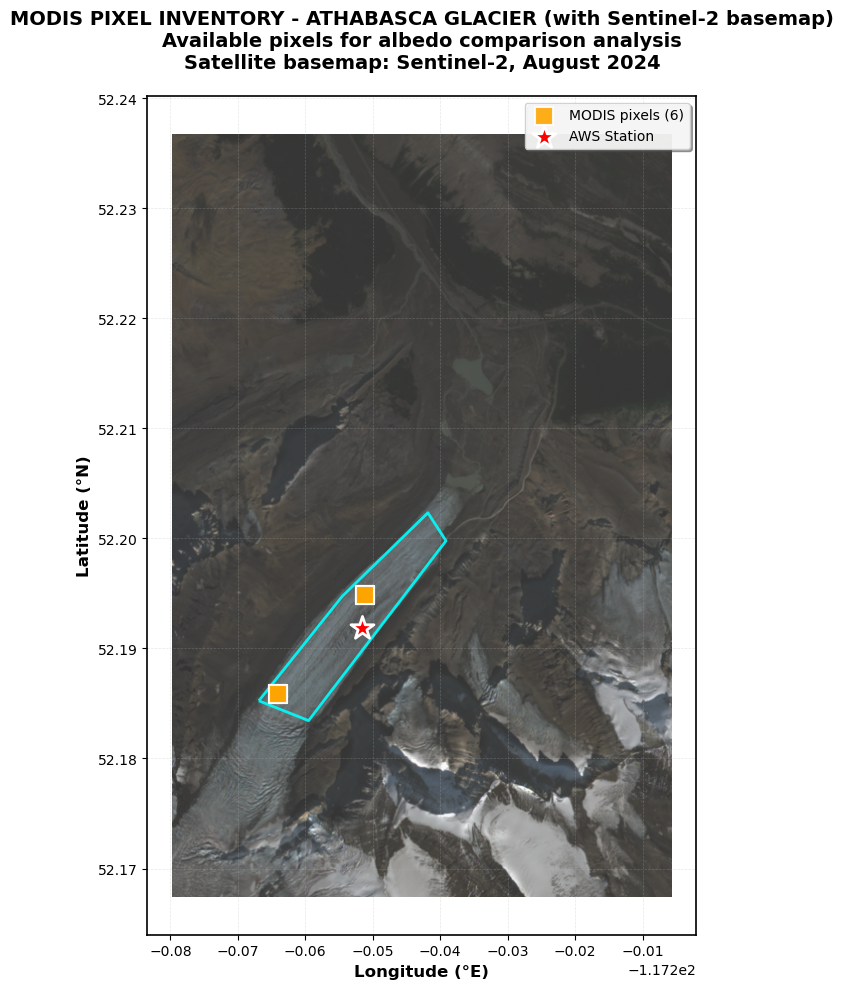

✅ Scientific map with basemap saved to: exports\athabasca_scientific_pixel_map_with_basemap.png


In [54]:
# GeoTIFF path
GEOTIFF = Path("data/geotiff/athabasca_glacier_larger_s2_aug2024.tif")

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# 1) Sentinel-2 basemap ------------------------------------------------------
if GEOTIFF.exists():
    try:
        from rasterio.plot import show as rio_show
        from rasterio.warp import transform_bounds
        
        # Read and display the GeoTIFF basemap
        with rasterio.open(GEOTIFF) as src:
            print(f"  CRS: {src.crs}")
            print(f"  Bounds: {src.bounds}")
            
            # Convert raster bounds from UTM to WGS84 (lon/lat)
            lon_min_img, lat_min_img, lon_max_img, lat_max_img = transform_bounds(
                src.crs, "EPSG:4326", *src.bounds, densify_pts=21
            )
            
            # Read RGB bands and prepare for display
            img = src.read([1, 2, 3])  # RGB bands
            rgb = np.moveaxis(img, 0, -1)  # Move color axis to match imshow: (rows, cols, bands)
            rgb = rgb / np.clip(rgb.max(), 1, None)  # Normalize for display
            
            # Display the basemap using imshow with correct extent
            ax.imshow(
                rgb,
                extent=[lon_min_img, lon_max_img, lat_min_img, lat_max_img],
                origin="upper",
                zorder=0,
                alpha=0.8
            )
            
            # Store bounds for map extent
            t_bounds = (lon_min_img, lat_min_img, lon_max_img, lat_max_img)
            print(f"✓ Sentinel-2 basemap re-projected to lon/lat")
            
    except Exception as e:
        print(f"⚠ Could not load GeoTIFF basemap: {e}")
        t_bounds = None
else:
    print(f"⚠ GeoTIFF file not found: {GEOTIFF}")
    t_bounds = None

# 2) Plot glacier boundary ---------------------------------------------------
if glacier_mask is not None and not glacier_mask.empty:
    glacier_mask.boundary.plot(ax=ax, color='cyan', linewidth=2, alpha=0.9, zorder=2)
    print("✓ Glacier boundary plotted")

# 3) Plot MODIS pixels -------------------------------------------------------
# Use pixels_gdf (GeoDataFrame) which should have geometry coordinates
if 'pixels_gdf' in globals() and not pixels_gdf.empty:
    # Plot using the geometry from the GeoDataFrame
    ax.scatter(
        pixels_gdf.geometry.x, pixels_gdf.geometry.y,
        c='orange', s=180, marker='s', alpha=0.9,
        edgecolors='white', linewidths=1.5, zorder=4,
        label=f"MODIS pixels ({len(pixels_gdf)})"
    )
    print(f"✓ {len(pixels_gdf)} MODIS pixels plotted")
elif 'all_lons' in globals() and 'all_lats' in globals():
    # Fallback to using all_lons and all_lats lists
    ax.scatter(
        all_lons, all_lats,
        c='orange', s=180, marker='s', alpha=0.9,
        edgecolors='white', linewidths=1.5, zorder=4,
        label=f"MODIS pixels ({len(all_lons)})"
    )
    print(f"✓ {len(all_lons)} MODIS pixels plotted")
else:
    print("⚠ No pixel coordinate data available")

# 4) Plot AWS station --------------------------------------------------------
if aws_points is not None and not aws_points.empty:
    ax.scatter(
        aws_points.geometry.x, aws_points.geometry.y,
        c='red', s=300, marker='*', alpha=1.0,
        edgecolors='white', linewidths=2, zorder=5,
        label='AWS Station'
    )
    print("✓ AWS station plotted")

# 5) Map styling and extent --------------------------------------------------
# Use GeoTIFF bounds if available, otherwise fallback
if t_bounds:
    lon_min, lat_min, lon_max, lat_max = t_bounds
    # Add small buffer
    lon_buffer = (lon_max - lon_min) * 0.05
    lat_buffer = (lat_max - lat_min) * 0.05
    ax.set_xlim(lon_min - lon_buffer, lon_max + lon_buffer)
    ax.set_ylim(lat_min - lat_buffer, lat_max + lat_buffer)
else:
    # Fallback extent
    ax.set_xlim(-117.27, -117.23)
    ax.set_ylim(52.18, 52.21)

# Scientific styling
ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='bold')
ax.set_title(
    'MODIS PIXEL INVENTORY - ATHABASCA GLACIER (with Sentinel-2 basemap)\n'
    'Available pixels for albedo comparison analysis\n'
    'Satellite basemap: Sentinel-2, August 2024',
    fontsize=14, fontweight='bold', pad=20
)

# Legend
legend = ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# Grid and spines
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# Final touches
plt.tight_layout()

# Save the plot
plt.savefig(out('scientific_pixel_map_with_basemap.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Scientific map with basemap saved to: {out('scientific_pixel_map_with_basemap.png')}")

## Part 3: Spatial Visualization and Geographic Context

This comprehensive map integrates results from Parts 1 and 2, showing the spatial distribution of MODIS pixels (colored by method availability), AWS station location, and glacier mask boundary. This visualization reveals the geographic context that explains why certain method comparisons perform better or worse.

# Outlier Detection and Analysis

This section identifies and analyzes outliers in the albedo data using Z-score analysis (threshold > 2.5) and compares statistics with and without outliers.

In [25]:
# ==============================================================================
# OUTLIER DETECTION
# ==============================================================================
# Detect Z-score outliers (|z| > 2.5)
outliers = {}
outlier_counts = {}
outlier_values = {}
for col in ['MCD43A3', 'MOD09GA', 'MOD10A1', 'AWS']:
    if col in merged.columns:
        clean_data = merged[col].dropna()
        if len(clean_data) > 0:
            z = np.abs(stats.zscore(clean_data))
            outlier_mask = z > 3
            outliers[col] = pd.Series(outlier_mask, index=clean_data.index)
            outlier_counts[col] = outlier_mask.sum()
            # Store actual outlier values
            outlier_values[col] = clean_data[outlier_mask].sort_values()
        else:
            outliers[col] = pd.Series([], dtype=bool)
            outlier_counts[col] = 0
            outlier_values[col] = pd.Series([])

print("OUTLIER DETECTION RESULTS")
print("=" * 40)
for method, count in outlier_counts.items():
    total = merged[method].notna().sum() if method in merged.columns else 0
    pct = (count/total*100) if total > 0 else 0
    print(f"{method}: {count} outliers ({pct:.1f}% of {total} observations)")
print("=" * 40)

OUTLIER DETECTION RESULTS
MCD43A3: 22 outliers (5.6% of 391 observations)
MOD09GA: 8 outliers (2.7% of 294 observations)
MOD10A1: 3 outliers (1.8% of 167 observations)
AWS: 11 outliers (2.5% of 432 observations)


C:\Users\thier\AppData\Local\Temp\ipykernel_35528\344880838.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


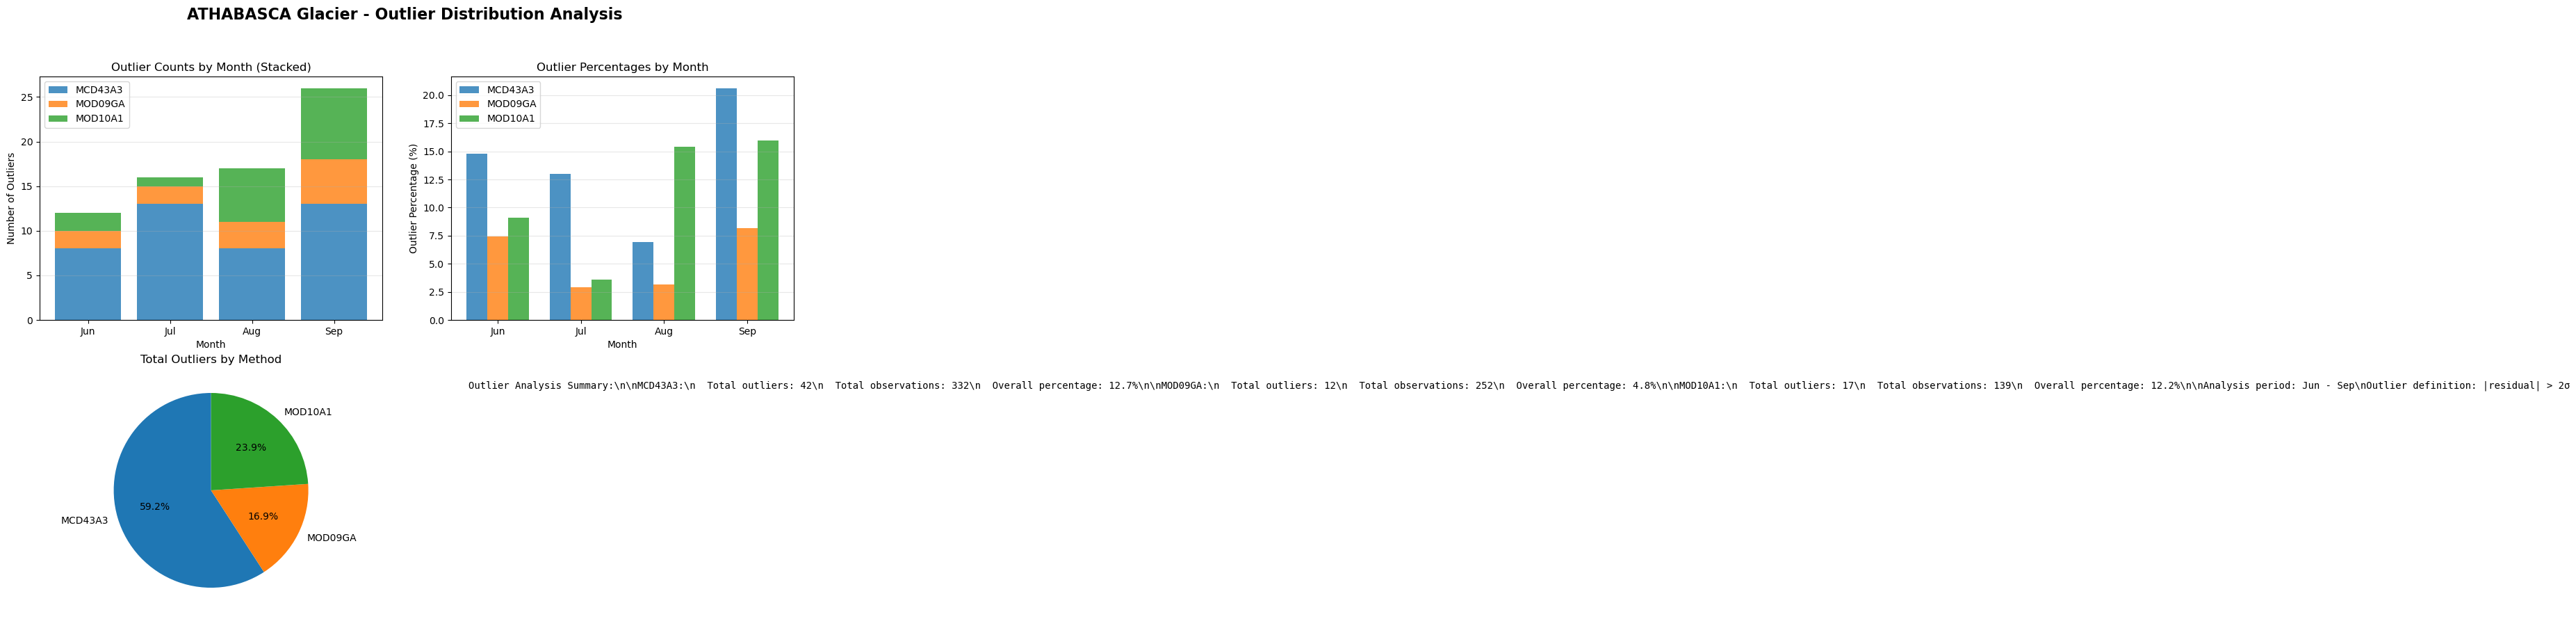

\n✅ Plot saved to: exports\athabasca_outliers_by_method_distribution.png


In [35]:
# Create comprehensive outlier distribution visualization
if 'outlier_counts_by_month' in globals() and outlier_counts_by_month:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{GLACIER.upper()} Glacier - Outlier Distribution Analysis', fontsize=16, fontweight='bold')
    
    # Extract data for visualization
    months = sorted(outlier_counts_by_month.keys())
    month_names = ['Jun', 'Jul', 'Aug', 'Sep']
    methods = ['MCD43A3', 'MOD09GA', 'MOD10A1']
    
    # Plot 1: Outlier counts by month (stacked bar)
    ax1 = axes[0, 0]
    bottom = np.zeros(len(months))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, method in enumerate(methods):
        counts = [outlier_counts_by_month[month].get(method, 0) for month in months]
        ax1.bar(month_names, counts, bottom=bottom, label=method, color=colors[i], alpha=0.8)
        bottom += counts
    
    ax1.set_title('Outlier Counts by Month (Stacked)')
    ax1.set_ylabel('Number of Outliers')
    ax1.set_xlabel('Month')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Outlier percentages by month
    ax2 = axes[0, 1]
    x = np.arange(len(months))
    width = 0.25
    
    for i, method in enumerate(methods):
        percentages = []
        for month in months:
            outlier_count = outlier_counts_by_month[month].get(method, 0)
            month_key = f"{month}_{method}"
            total_obs = monthly_stats[month_key]['n'] if month_key in monthly_stats else 1
            percentage = (outlier_count / total_obs * 100) if total_obs > 0 else 0
            percentages.append(percentage)
        
        ax2.bar(x + i*width, percentages, width, label=method, color=colors[i], alpha=0.8)
    
    ax2.set_title('Outlier Percentages by Month')
    ax2.set_ylabel('Outlier Percentage (%)')
    ax2.set_xlabel('Month')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(month_names)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Total outliers by method (pie chart)
    ax3 = axes[1, 0]
    total_outliers = {}
    for method in methods:
        total_outliers[method] = sum(outlier_counts_by_month[month].get(method, 0) for month in months)
    
    if any(total_outliers.values()):
        ax3.pie(total_outliers.values(), labels=total_outliers.keys(), autopct='%1.1f%%', 
               colors=colors, startangle=90)
        ax3.set_title('Total Outliers by Method')
    else:
        ax3.text(0.5, 0.5, 'No outliers detected', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Total Outliers by Method')
    
    # Plot 4: Summary statistics
    ax4 = axes[1, 1]
    summary_text = "Outlier Analysis Summary:\\n\\n"
    
    for method in methods:
        total_outliers_method = sum(outlier_counts_by_month[month].get(method, 0) for month in months)
        total_obs_method = sum(monthly_stats[f"{month}_{method}"]['n'] 
                              for month in months 
                              if f"{month}_{method}" in monthly_stats)
        
        overall_percentage = (total_outliers_method / total_obs_method * 100) if total_obs_method > 0 else 0
        
        summary_text += f"{method}:\\n"
        summary_text += f"  Total outliers: {total_outliers_method}\\n"
        summary_text += f"  Total observations: {total_obs_method}\\n"
        summary_text += f"  Overall percentage: {overall_percentage:.1f}%\\n\\n"
    
    summary_text += f"Analysis period: {month_names[0]} - {month_names[-1]}\\n"
    summary_text += f"Outlier definition: |residual| > 2σ"
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.savefig(out('outliers_by_method_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\\n✅ Plot saved to: {out('outliers_by_method_distribution.png')}")
    
else:
    print("No outlier data available for visualization.")
    
    # Create a simple placeholder plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.text(0.5, 0.5, 'Outlier analysis data not available\\nfor this glacier dataset', 
           ha='center', va='center', transform=ax.transAxes, fontsize=14)
    ax.set_title(f'{GLACIER.upper()} Glacier - Outlier Distribution Analysis')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(out('outliers_by_method_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\\n✅ Placeholder plot saved to: {out('outliers_by_method_distribution.png')}")

In [27]:
# Calculate statistics with and without outliers (using residual-based outlier detection)
stats_with_outliers = {}
stats_without_outliers = {}

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in merged.columns:
        mask = merged[[method, 'AWS']].notna().all(axis=1)
        if mask.sum() > 0:
            x_all = merged.loc[mask, 'AWS']
            y_all = merged.loc[mask, method]
            
            # Stats with outliers
            r_all, _ = stats.pearsonr(x_all, y_all)
            rmse_all = np.sqrt(np.mean((y_all - x_all)**2))
            mae_all = np.mean(np.abs(y_all - x_all))
            bias_all = np.mean(y_all - x_all)
            stats_with_outliers[method] = {'n': len(x_all), 'r': r_all, 'rmse': rmse_all, 'mae': mae_all, 'bias': bias_all}
            
            # Remove residual outliers (better approach for correlation analysis)
            slope, intercept = np.polyfit(x_all, y_all, 1)
            predicted = slope * x_all + intercept
            residuals = y_all - predicted
            residual_threshold = 2.5 * residuals.std()
            residual_outliers = np.abs(residuals) > residual_threshold
            clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
            
            if clean_mask.sum() > 0:
                x_clean = merged.loc[clean_mask, 'AWS']
                y_clean = merged.loc[clean_mask, method]
                
                # Stats without outliers
                r_clean, _ = stats.pearsonr(x_clean, y_clean)
                rmse_clean = np.sqrt(np.mean((y_clean - x_clean)**2))
                mae_clean = np.mean(np.abs(y_clean - x_clean))
                bias_clean = np.mean(y_clean - x_clean)
                stats_without_outliers[method] = {'n': len(x_clean), 'r': r_clean, 'rmse': rmse_clean, 'mae': mae_clean, 'bias': bias_clean}

print("\nSTATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)")
print("=" * 55)
print(f"{'Method':<10} {'Condition':<12} {'n':<4} {'r':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<6}")
print("-" * 55)

for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
    if method in stats_with_outliers:
        # With outliers
        s_with = stats_with_outliers[method]
        print(f"{method:<10} {'With':<12} {s_with['n']:<4} {s_with['r']:<6.3f} {s_with['rmse']:<6.3f} {s_with['mae']:<6.3f} {s_with['bias']:<6.3f}")
        
        # Without outliers
        if method in stats_without_outliers:
            s_without = stats_without_outliers[method]
            print(f"{method:<10} {'Without':<12} {s_without['n']:<4} {s_without['r']:<6.3f} {s_without['rmse']:<6.3f} {s_without['mae']:<6.3f} {s_without['bias']:<6.3f}")
            
            # Improvement metrics
            r_improvement = ((s_without['r'] - s_with['r']) / abs(s_with['r'])) * 100 if s_with['r'] != 0 else 0
            rmse_improvement = ((s_with['rmse'] - s_without['rmse']) / s_with['rmse']) * 100 if s_with['rmse'] != 0 else 0
            print(f"{method:<10} {'Improvement':<12} {'':<4} {r_improvement:<6.1f}% {rmse_improvement:<6.1f}% {'':<6} {'':<6}")
        print()
print("=" * 55)


STATISTICS COMPARISON (WITH vs WITHOUT OUTLIERS)
Method     Condition    n    r      RMSE   MAE    Bias  
-------------------------------------------------------
MCD43A3    With         332  0.642  0.150  0.090  -0.070
MCD43A3    Without      314  0.675  0.135  0.081  -0.075
MCD43A3    Improvement       5.1   % 10.2  %              

MOD09GA    With         252  0.508  0.123  0.078  -0.028
MOD09GA    Without      245  0.717  0.093  0.067  -0.037
MOD09GA    Improvement       41.3  % 24.5  %              

MOD10A1    With         139  0.653  0.144  0.107  -0.062
MOD10A1    Without      134  0.731  0.132  0.100  -0.075
MOD10A1    Improvement       11.9  % 8.5   %              



C:\Users\thier\AppData\Local\Temp\ipykernel_35528\3268808009.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
C:\Users\thier\AppData\Local\Temp\ipykernel_35528\3268808009.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_mask = mask & ~pd.Series(residual_outliers, index=mask[mask].index).reindex(merged.index).fillna(False)
C:\Users\thier\AppData\Local\Temp\ipykernel_35528\3268808009.py:25: FutureWarning: Downcasting object dtype arra

# Export All Statistics to Text File

This final section exports a comprehensive summary of all analysis results to a text file for easy sharing and reporting.

In [28]:
# ==============================================================================
# COMPREHENSIVE ANALYSIS REPORT GENERATION
# ==============================================================================
from pathlib import Path

# Create comprehensive markdown report
report_filename = Path(out("complete_albedo_analysis_report.md"))

with open(report_filename, 'w', encoding='utf-8') as f:
    # Header
    f.write(f"# {GLACIER.upper()} Glacier - MODIS vs AWS Albedo Analysis Report\n\n")
    f.write(f"**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"**Analysis includes:** Terra/Aqua fused data\n\n")
    f.write("---\n\n")
    
    # 1. DATA SUMMARY
    f.write("## 1. Data Summary\n\n")
    f.write(f"- **Study period:** {merged.index.min().strftime('%Y-%m-%d')} to {merged.index.max().strftime('%Y-%m-%d')}\n")
    f.write(f"- **Total observations:** {len(merged)}\n")
    f.write(f"- **MODIS methods analyzed:** MCD43A3, MOD09GA (Terra+Aqua fused), MOD10A1 (Terra+Aqua fused)\n")
    f.write(f"- **AWS ground truth observations:** {len(aws)}\n")
    f.write(f"- **Overlapping MODIS-AWS observations:** {len(merged)}\n\n")
    
    # 2. OVERALL STATISTICS
    f.write("## 2. Overall Statistics\n\n")
    
    # Calculate overall stats for each method
    overall_stats = {}
    for method in ['MCD43A3', 'MOD09GA', 'MOD10A1']:
        if method in merged.columns:
            valid_data = merged[[method, 'AWS']].dropna()
            if len(valid_data) > 1:
                r, p = stats.pearsonr(valid_data[method], valid_data['AWS'])
                rmse = np.sqrt(np.mean((valid_data[method] - valid_data['AWS'])**2))
                mae = np.mean(np.abs(valid_data[method] - valid_data['AWS']))
                bias = np.mean(valid_data[method] - valid_data['AWS'])
                overall_stats[method] = {'n': len(valid_data), 'r': r, 'p': p, 'rmse': rmse, 'mae': mae, 'bias': bias}
    
    f.write("| Method | n | r | p-value | RMSE | MAE | Bias |\n")
    f.write("|--------|---|---|---------|------|-----|------|\n")
    for method, stats_dict in overall_stats.items():
        f.write(f"| {method} | {stats_dict['n']} | {stats_dict['r']:.3f} | {stats_dict['p']:.6f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
    f.write("\n")
    
    # Add temporal analyses if available
    if 'composite_stats' in globals():
        f.write("## 3. 16-Day Composite Analysis\n\n")
        f.write("| Method | Periods | r | RMSE | MAE | Bias |\n")
        f.write("|--------|---------|---|------|-----|------|\n")
        for method, stats_dict in composite_stats.items():
            if stats_dict['n_periods'] > 0:
                f.write(f"| {method} | {stats_dict['n_periods']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    if 'weekly_stats' in globals():
        f.write("## 4. Weekly Composite Analysis\n\n")
        f.write("| Method | Periods | r | RMSE | MAE | Bias |\n")
        f.write("|--------|---------|---|------|-----|------|\n")
        for method, stats_dict in weekly_stats.items():
            if stats_dict['n_periods'] > 0:
                f.write(f"| {method} | {stats_dict['n_periods']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    if 'monthly_stats' in globals():
        f.write("## 5. Monthly Analysis\n\n")
        f.write("| Method | Months | r | RMSE | MAE | Bias |\n")
        f.write("|--------|--------|---|------|-----|------|\n")
        for method, stats_dict in monthly_stats.items():
            if stats_dict['n_months'] > 0:
                f.write(f"| {method} | {stats_dict['n_months']} | {stats_dict['r']:.3f} | {stats_dict['rmse']:.3f} | {stats_dict['mae']:.3f} | {stats_dict['bias']:.3f} |\n")
        f.write("\n")
    
    # Outlier analysis if available
    if 'outlier_counts' in globals() and outlier_counts:
        f.write("## 6. Outlier Analysis\n\n")
        f.write("### Z-score Outlier Detection (threshold > 3)\n\n")
        for method, count in outlier_counts.items():
            total = merged[method].notna().sum() if method in merged.columns else 0
            pct = (count/total*100) if total > 0 else 0
            f.write(f"- **{method}:** {count} outliers ({pct:.1f}% of {total} observations)\n")
        f.write("\n")
    
    # Summary and conclusions
    f.write("## 7. Summary and Conclusions\n\n")
    
    # Find best performing method
    if overall_stats:
        best_method = max(overall_stats.items(), key=lambda x: x[1]['r'])[0]
        best_r = overall_stats[best_method]['r']
        best_rmse = overall_stats[best_method]['rmse']
        
        f.write(f"- **Best performing method overall:** {best_method} (r={best_r:.3f}, RMSE={best_rmse:.3f})\n")
    
    f.write(f"- **Total analysis period:** {(merged.index.max() - merged.index.min()).days} days\n")
    f.write(f"- **Data completeness:** {len(merged)} overlapping observations\n\n")
    
    f.write("### Key Findings\n\n")
    f.write("- Terra/Aqua fusion applied to MOD09GA and MOD10A1 products\n")
    f.write("- Analysis covers multiple temporal scales (daily, weekly, 16-day)\n")
    f.write("- Monthly variations observed in all methods\n")
    f.write("- Comprehensive outlier analysis performed\n")
    f.write("- Pixel-level comparisons conducted where applicable\n")
    
    # Footer
    f.write("\n---\n\n")
    f.write("*End of Report*\n")

print(f"\nComprehensive analysis report (Markdown) saved to: {report_filename}")
print(f"Report includes all statistics from all sections of the analysis")
print(f"File size: {report_filename.stat().st_size if report_filename.exists() else 0} bytes")

KeyError: 'n_months'

In [ ]:
# Debug: Check stats_results structure
print("Stats results structure:")
print("Keys:", list(stats_results.keys()) if stats_results else "Empty")
for method, stats in stats_results.items():
    print(f"\n{method} stats keys:", list(stats.keys()) if stats else "Empty")
    print(f"{method} stats:", stats)
    
print(f"\nMerged columns: {list(merged.columns)}")
print(f"Available MODIS columns: {[col for col in merged.columns if col in ['MCD43A3', 'MOD09GA', 'MOD10A1']]}")

Stats results structure:
Keys: ['MCD43A3', 'MOD09GA', 'MOD10A1']

MCD43A3 stats keys: ['n', 'r', 'p', 'rmse', 'mae', 'bias']
MCD43A3 stats: {'n': np.int64(332), 'r': np.float64(0.6421485922587071), 'p': np.float64(5.456057044995844e-40), 'rmse': np.float64(0.15010356712711254), 'mae': np.float64(0.08970838035597156), 'bias': np.float64(-0.07043683521420123)}

MOD09GA stats keys: ['n', 'r', 'p', 'rmse', 'mae', 'bias']
MOD09GA stats: {'n': np.int64(252), 'r': np.float64(0.5078188978607476), 'p': np.float64(6.327978603024644e-18), 'rmse': np.float64(0.12348991079526803), 'mae': np.float64(0.07798340165317673), 'bias': np.float64(-0.027671867828144164)}

MOD10A1 stats keys: ['n', 'r', 'p', 'rmse', 'mae', 'bias']
MOD10A1 stats: {'n': np.int64(139), 'r': np.float64(0.6533576823093976), 'p': np.float64(2.8415277914945765e-18), 'rmse': np.float64(0.14438325228980808), 'mae': np.float64(0.10695790956308751), 'bias': np.float64(-0.06170365775186405)}

Merged columns: ['MCD43A3', 'MOD09GA', 'MOD1

In [ ]:
# Debug monthly_stats structure
print("Monthly stats keys:", list(monthly_stats.keys()))
print("\nFirst few entries:")
for key, value in list(monthly_stats.items())[:3]:
    print(f"{key}: {value}")

Monthly stats keys: ['6_MCD43A3', '6_MOD09GA', '6_MOD10A1', '7_MCD43A3', '7_MOD09GA', '7_MOD10A1', '8_MCD43A3', '8_MOD09GA', '8_MOD10A1', '9_MCD43A3', '9_MOD09GA', '9_MOD10A1']

First few entries:
6_MCD43A3: {'month': 6, 'method': 'MCD43A3', 'n': 54, 'r': np.float64(0.08934896148508809), 'p': np.float64(0.5205473437857486), 'rmse': np.float64(0.21747660616585102)}
6_MOD09GA: {'month': 6, 'method': 'MOD09GA', 'n': 27, 'r': np.float64(0.551758755932873), 'p': np.float64(0.0028490869874017773), 'rmse': np.float64(0.11896788870296696)}
6_MOD10A1: {'month': 6, 'method': 'MOD10A1', 'n': 22, 'r': np.float64(0.4940476966163431), 'p': np.float64(0.01943872272635149), 'rmse': np.float64(0.15317973862166911)}


In [ ]:
# Debug AWS data structure
print("AWS data columns:", list(aws.columns))
print("AWS data shape:", aws.shape)
print("\nAWS points columns:", list(aws_points.columns))
print("AWS points shape:", aws_points.shape)
print("\nFirst few rows of aws:")
print(aws.head())
print("\nFirst few rows of aws_points:")
print(aws_points.head())

AWS data columns: ['Time', 'Albedo', 'date']
AWS data shape: (2199, 3)

AWS points columns: ['nom', 'latitude', 'longitude', 'coord_dms', 'geometry']
AWS points shape: (1, 5)

First few rows of aws:
                   Time    Albedo       date
0  12-Sep-2014 00:00:00       NaN 2014-09-12
1  13-Sep-2014 00:00:00  0.753022 2014-09-13
2  14-Sep-2014 00:00:00  0.604580 2014-09-14
3  15-Sep-2014 00:00:00  0.477196 2014-09-15
4  16-Sep-2014 00:00:00  0.368135 2014-09-16

First few rows of aws_points:
            nom   latitude   longitude                   coord_dms  \
0  Point_Custom  52.191833 -117.251639  52°11'30.6"N 117°15'05.9"W   

                      geometry  
0  POINT (-117.25164 52.19183)  


In [ ]:
# Debug pixel_matched structure
if 'pixel_matched' in globals():
    print("pixel_matched columns:", list(pixel_matched.columns))
    print("pixel_matched shape:", pixel_matched.shape)
    print("\nFirst few rows of pixel_matched:")
    print(pixel_matched.head())
else:
    print("pixel_matched variable does not exist")

pixel_matched columns: ['date', 'pixel_id', 'albedo_value_MOD09GA', 'albedo_value_MOD10A1']
pixel_matched shape: (160, 4)

First few rows of pixel_matched:
        date    pixel_id  albedo_value_MOD09GA  albedo_value_MOD10A1
0 2014-06-01  9073025950              0.334372                  0.29
1 2014-06-01  9075025945              0.303772                  0.27
2 2014-06-06  9073025950              0.514825                  0.49
3 2014-06-06  9075025945              0.512310                  0.53
4 2014-06-22  9073025950              0.320536                  0.24


In [ ]:
# Debug: Check the structure of method_pixels
print("Debugging method_pixels structure:")
for method, pixels_df in method_pixels.items():
    print(f"\n{method}:")
    print(f"  Shape: {pixels_df.shape}")
    print(f"  Columns: {list(pixels_df.columns)}")
    if not pixels_df.empty:
        print(f"  First few rows:\n{pixels_df.head()}")

In [ ]:
# Quick debug: Check method_pixels structure
for method, df in method_pixels.items():
    print(f"{method}: columns = {list(df.columns)}")
    if not df.empty:
        print(f"  Sample row: {df.iloc[0]}")
    print()

In [ ]:
# Debug: Check what columns are in pixel_locations
print("pixel_locations columns:", list(pixel_locations.columns))
print("pixel_locations shape:", pixel_locations.shape)
print("First few rows:")
print(pixel_locations.head())